<ipython-input-7-32ecb1e8dacd>:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', df['segment_id'].nunique())


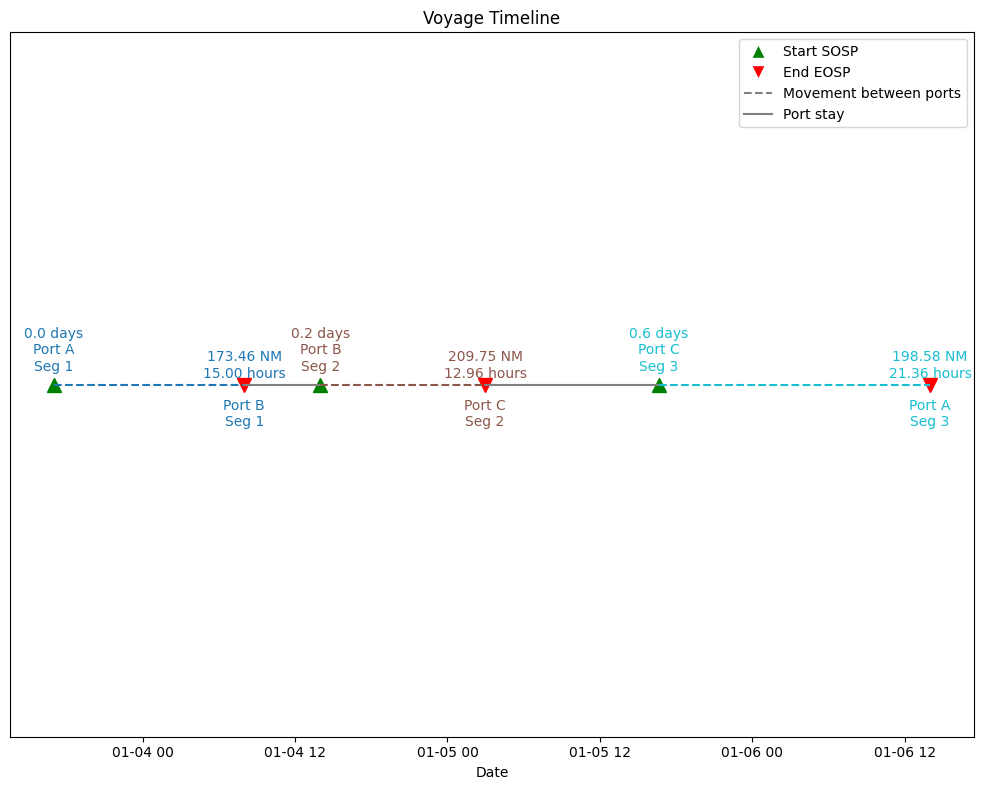

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, asin

# Function to generate sample voyages data
def generate_sample_data():
    data = {
        'id': [1, 2, 3, 4, 5, 6],
        'event': ['SOSP', 'EOSP', 'SOSP', 'EOSP', 'SOSP', 'EOSP'],
        'dateStamp': [43831, 43832, 43832, 43833, 43833, 43834],
        'timeStamp': [0.708333, 0.333333, 0.583333, 0.123333, 0.693333, 0.583333],
        'voyage_From': ['Port A', 'Port B', 'Port B', 'Port C', 'Port C', 'Port A'],
        'lat': [34.0522, 36.7783, 36.7783, 36.1716, 36.1716, 34.0522],
        'lon': [-118.2437, -119.4179, -119.4179, -115.1391, -115.1391, -118.2437],
        'imo_num': ['9434761', '9434761', '9434761', '9434761', '9434761', '9434761'],
        'voyage_Id': ['6', '6', '6', '6', '6', '6'],
        'allocatedVoyageId': [None, None, None, None, None, None]
    }
    df = pd.DataFrame(data)
    return df

# Function to calculate haversine distance between two points in nautical miles using pre-defined formulas
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3440.065  # Radius of the Earth in nautical miles
    # Conversion of coordinates into radians
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    # Distance between latitudes and longitudes
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    # Pre-defined formula for the distance calculation
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    distance_nm = R * c # Conversion of distance from kilometers to nautical miles
    return distance_nm

# Function to process voyages data and perform calculations
def process_voyages_data(df):
    try:
        # Convert the event timestamps into UTC from the given format
        df['event_utc'] = pd.to_datetime('1900-01-01') + pd.to_timedelta(df['dateStamp'], unit='D') + pd.to_timedelta(df['timeStamp'] * 24, unit='H')
        df['prev_event'] = df['event'].shift(1)
        df['prev_event_utc'] = df['event_utc'].shift(1)
        df['prev_voyage_From'] = df['voyage_From'].shift(1)
        df['prev_lat'] = df['lat'].shift(1)
        df['prev_lon'] = df['lon'].shift(1)
        # Calculate the distance between geographic coordinates in nautical miles
        df['distance_nm'] = np.where(df['event'] == 'EOSP',
                                     df.apply(lambda row: haversine_distance(row['prev_lat'], row['prev_lon'], row['lat'], row['lon']), axis=1),
                                     None)
        # Calculate the Sailing time hours travelled between two ports in hours
        df['sailing_time_hours'] = np.where(df['event'] == 'EOSP',
                                            (df['event_utc'] - df['prev_event_utc']).dt.total_seconds() / 3600,
                                            None)
        # Calculate the port stay duration of a ship at a port in days
        df['port_stay_duration_days'] = np.where((df['event'] == 'SOSP') & (df['voyage_From'] == 'Port A'),
                                                 0.0,
                                                 (df['event_utc'] - df['prev_event_utc']).dt.total_seconds() / (60 * 60 * 24))
        # Segment different voyage stages based on series of SOSP and EOSP events
        segment_id = 0
        segment_ids = []
        # Identify a new segment at each SOSP-EOSP cycle
        for index, row in df.iterrows():
            if row['event'] == 'SOSP':
                segment_id += 1
            segment_ids.append(segment_id)
        df['segment_id'] = segment_ids

        return df.dropna(subset=['event']).reset_index(drop=True)

    # except block for catching any exceptions in the process_voyages_data
    except Exception as e:
        print(f"Error in process_voyages_data: {e}")

# Function to plot voyage timeline visualization
def plot_voyage_timeline(df):
    try:
        # create a figure of size (12,8) and a set of subplots to plot the data
        fig, ax = plt.subplots(figsize=(10, 8))
        # Generate a color map to differentiate the semgments on the plot with different colors
        colors = plt.cm.get_cmap('tab10', df['segment_id'].nunique())

        #Loop through each row for the data visualisation
        for idx, row in df.iterrows():
            color = colors(row['segment_id'] - 1)  # -1 to match color index, color indices starts from 0
            if row['event'] == 'SOSP':
                ax.plot(row['event_utc'], 0, marker='^', color='green', markersize=10) # '^' in green indicates the Start of Sea Passage(SOSP)
                # Annotate the below mentioned details on the plot at their respective ports
                ax.annotate(f'{row["port_stay_duration_days"]:.1f} days\n{row["voyage_From"]}\nSeg {row["segment_id"]}',
                            (row['event_utc'], 0), textcoords="offset points", xytext=(0,10), ha='center', color=color)
            elif row['event'] == 'EOSP':
                ax.plot(row['event_utc'], 0, marker='v', color='red', markersize=10) # 'v' in red indicates the End of Sea Passage(EOSP)
                distance_nm = row['distance_nm']
                # annotate the below mentioned details at their respective ports
                annotation_text = f'{distance_nm:.2f} NM\n{row["sailing_time_hours"]:.2f} hours\n\n{row["voyage_From"]}\nSeg {row["segment_id"]}'
                ax.annotate(annotation_text,
                            (row['event_utc'], 0), textcoords="offset points", xytext=(0, -30), ha='center', color=color)


        # Connect the ports with segment-specific colors to show the transportation of the vessel
        for i in range(1, len(df)):
            if df.loc[i, 'segment_id'] == df.loc[i-1, 'segment_id']:
                color = colors(df.loc[i, 'segment_id'] - 1)
                ax.plot([df.loc[i-1, 'event_utc'], df.loc[i, 'event_utc']], [0, 0], color=color, linestyle='--') # -- indicates the transportation of the vessel from one port to other
            else:
                prev_color = colors(df.loc[i-1, 'segment_id'] - 1)
                next_color = colors(df.loc[i, 'segment_id'] - 1)
                ax.plot([df.loc[i-1, 'event_utc'], df.loc[i, 'event_utc']], [0, 0], color='gray', linestyle='-') # - indicates the port stay at a port

        # Final plot adjustments
        ax.set_yticks([]) # remove y-axis ticks
        ax.set_xlabel('Date') # Label the x-axis as Date
        ax.set_title('Voyage Timeline')# Set the plot title to Voyage Timeline
        # Add the customized legend
        sosp_marker = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10)
        eosp_marker = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10)
        movement_line = plt.Line2D([0], [1], color='gray', linestyle='--')
        stay_line = plt.Line2D([0], [1], color='gray', linestyle='-')

        ax.legend([sosp_marker, eosp_marker, movement_line, stay_line],
                  ['Start SOSP', 'End EOSP', 'Movement between ports', 'Port stay'],
                  loc='upper right')

        plt.tight_layout() # Adjust the layout to fit everything properly
        plt.show() # Show the plot

    except Exception as e:
        print(f"Error in plot_voyage_timeline: {e}")

# Main function to execute the script
if __name__ == "__main__":
    try:
        df = generate_sample_data() # Generate Sample data
        df_processed = process_voyages_data(df) # Process the data to calculate metrics and segment voyages
        plot_voyage_timeline(df_processed) # Plot the voyage timeline visualisation
    # except block for catching any exceptions in the scripts
    except Exception as e:
        print(f"Main script error: {e}")

